In [1]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/'My Drive'/'All_Repos'/Self-Driving-Car-NanoDegree/CarND-Advanced-Lane-Lines

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/All_Repos/Self-Driving-Car-NanoDegree/CarND-Advanced-Lane-Lines


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import glob
%matplotlib inline

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3170304/45929032 bytes (6.9%)6717440/45929032 bytes (14.6%)10575872/45929032 bytes (23.0%)14491648/45929032 bytes (31.6%)18407424/45929032 bytes (40.1%)21995520/45929032 bytes (47.9%)25190400/45929032 bytes (54.8%)29057024/45929032 bytes (63.3%)32645120/45929032 bytes (71.1%)36438016/45929032 bytes (79.3%)40255488/45929032 bytes (87.6%)44072960/45929032 bytes (96.0%)

## Camera Calibration

Create the camera matrix and distortion coefficient and write it to a pickle

In [0]:
import pickle

images = glob.glob('camera_cal/calibration*.jpg')
objpoints = []
imgpoints = []
  
objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
for image in images:
  img = cv2.imread(image)
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
  ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
  if ret == True:
    imgpoints.append(corners)
    objpoints.append(objp)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

camera_cal = {"mtx":mtx,"dist":dist}

pickle.dump(camera_cal,open("pickle/cal.p","wb"))

Read mxt and dist from pickle

In [0]:
import pickle
camera_cal = pickle.load( open( "pickle/cal.p", "rb" ) )

mtx = camera_cal["mtx"]
dist = camera_cal["dist"]

# Disrtotion Correction

In [4]:
images = glob.glob('test_images/*.jpg')
fig, axs = plt.subplots(8, 2, figsize=(20, 40))
for ax, img in zip(axs, images):
  path = img
  img = cv2.imread(img)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  ax[0].imshow(img)
  ax[0].set_title(path)
  undist = cv2.undistort(img, mtx, dist, None, mtx)
  ax[1].imshow(undist)
  
plt.show() 
  

Output hidden; open in https://colab.research.google.com to view.

## Threshold

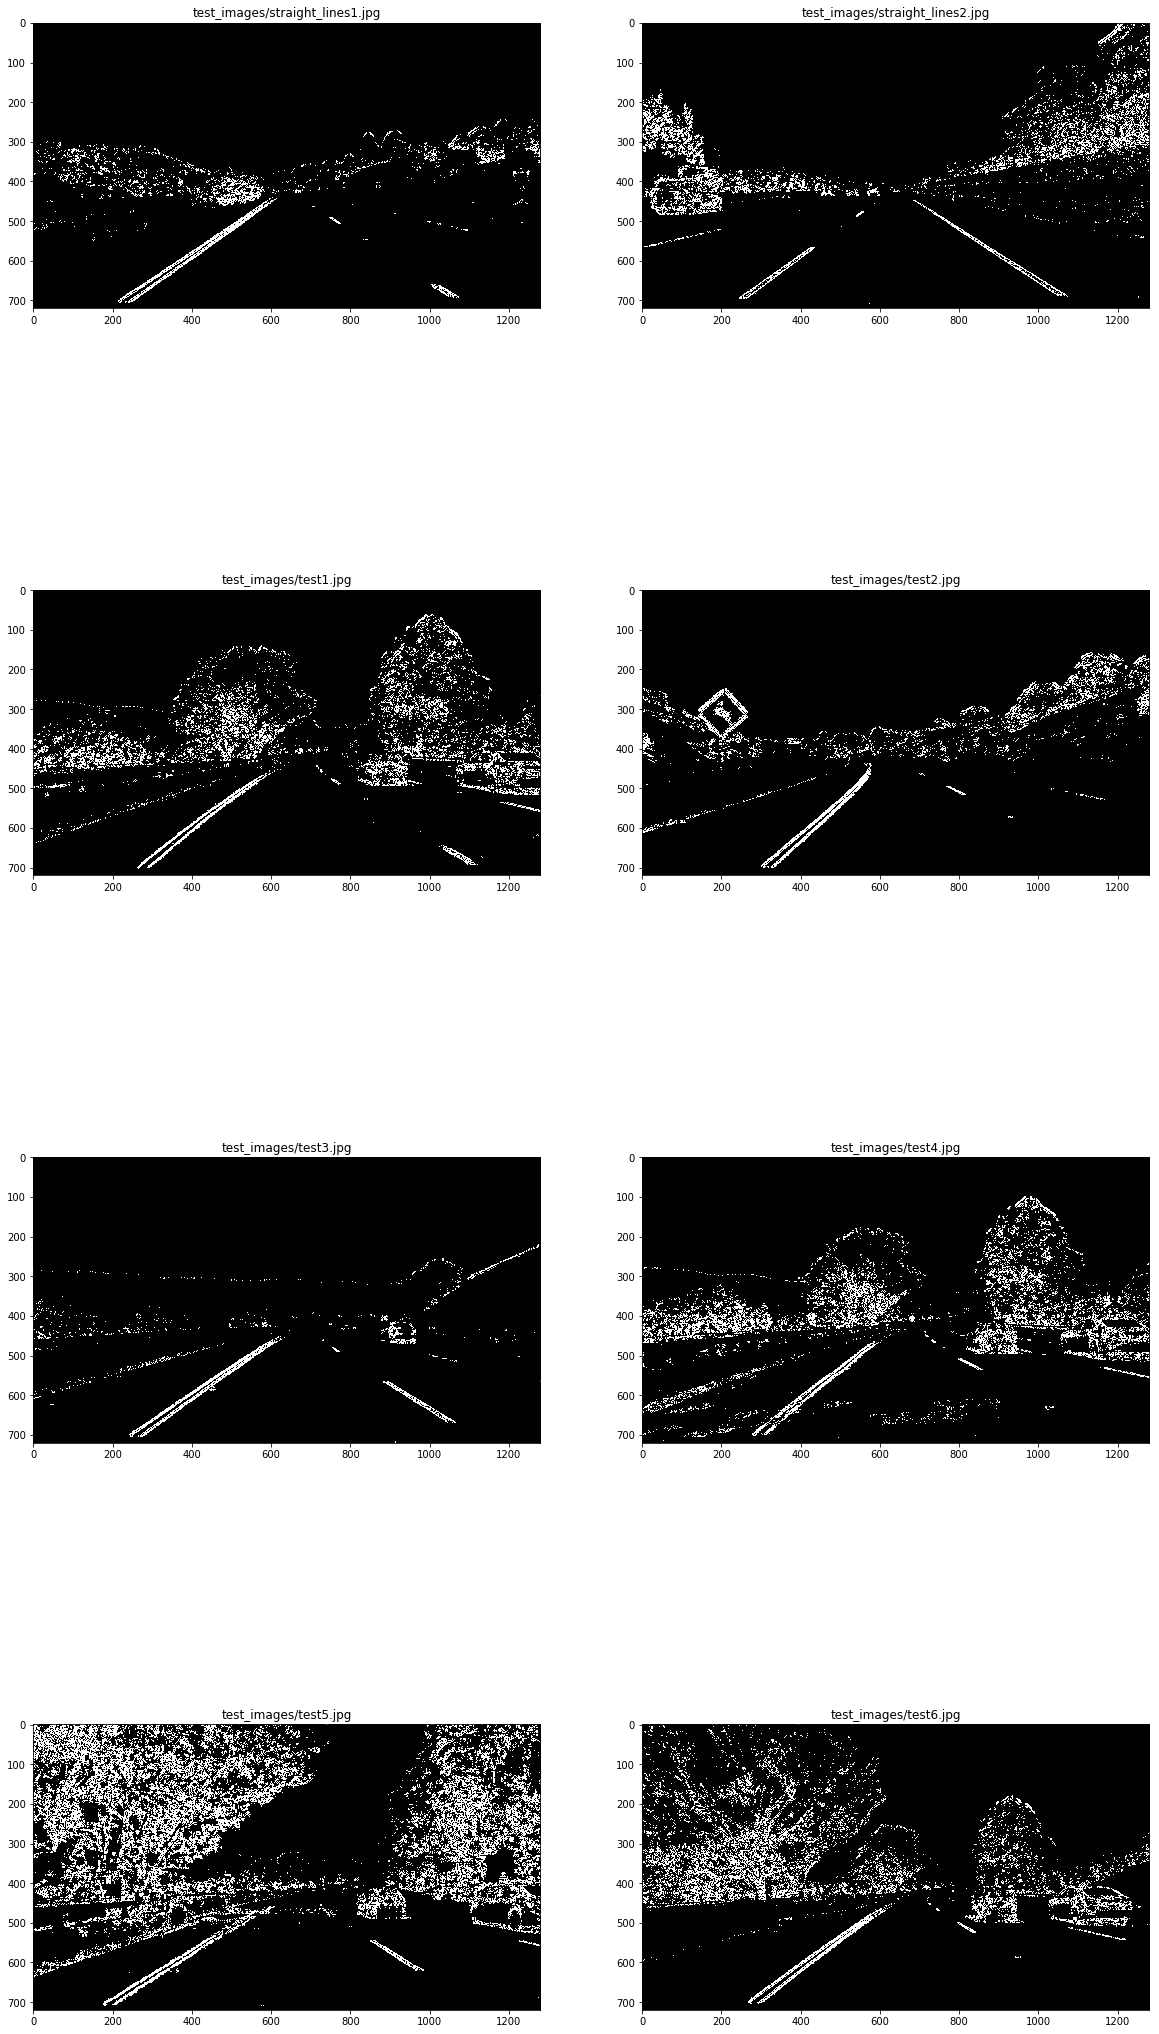

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    #n, bins, patches = plt.hist(s_channel[500:,:].ravel(),bins=5)
    #s_channel[(s_channel > thresh[0]) & (s_channel < thresh[1])] = 0
    if orient == 'x':
        sobelx = cv2.Sobel(s_channel,cv2.CV_64F,1,0,ksize=sobel_kernel)
        scaled = np.abs(255*sobelx/np.max(sobelx)).astype('uint8')
    elif orient == 'y':
        sobely = cv2.Sobel(s_channel,cv2.CV_64F,0,1,ksize=sobel_kernel)
        scaled = np.abs(255*sobely/np.max(sobely)).astype('uint8')

    binary = np.zeros_like(scaled)
    binary[(scaled > thresh[0]) & (scaled <= thresh[1])] = 1
    
    return binary

 
def threshold_mask(img, sobel_kernel=3,thresh=(10, 255)):
        
    sxbinary = abs_sobel_thresh(img.copy(), orient='x', sobel_kernel=sobel_kernel, thresh=thresh)
    sybinary = abs_sobel_thresh(img.copy(), orient='y', sobel_kernel=sobel_kernel, thresh=thresh)
    
    combined = np.zeros_like(sxbinary)
    combined[((sxbinary == 1) & (sybinary == 1)) ] = 1
        
    return combined
  
images = glob.glob('test_images/*.jpg')
fig, axs = plt.subplots(4, 2, figsize=(20, 40))
for ax, img in zip(axs.flat, images):
  path = img
  img = cv2.imread(img)
  #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  undist = cv2.undistort(img, mtx, dist, None, mtx)
  result = threshold_mask(undist)
  ax.imshow(result,cmap='gray')
  ax.set_title(path)
  
plt.show() 

## Perspective Transform

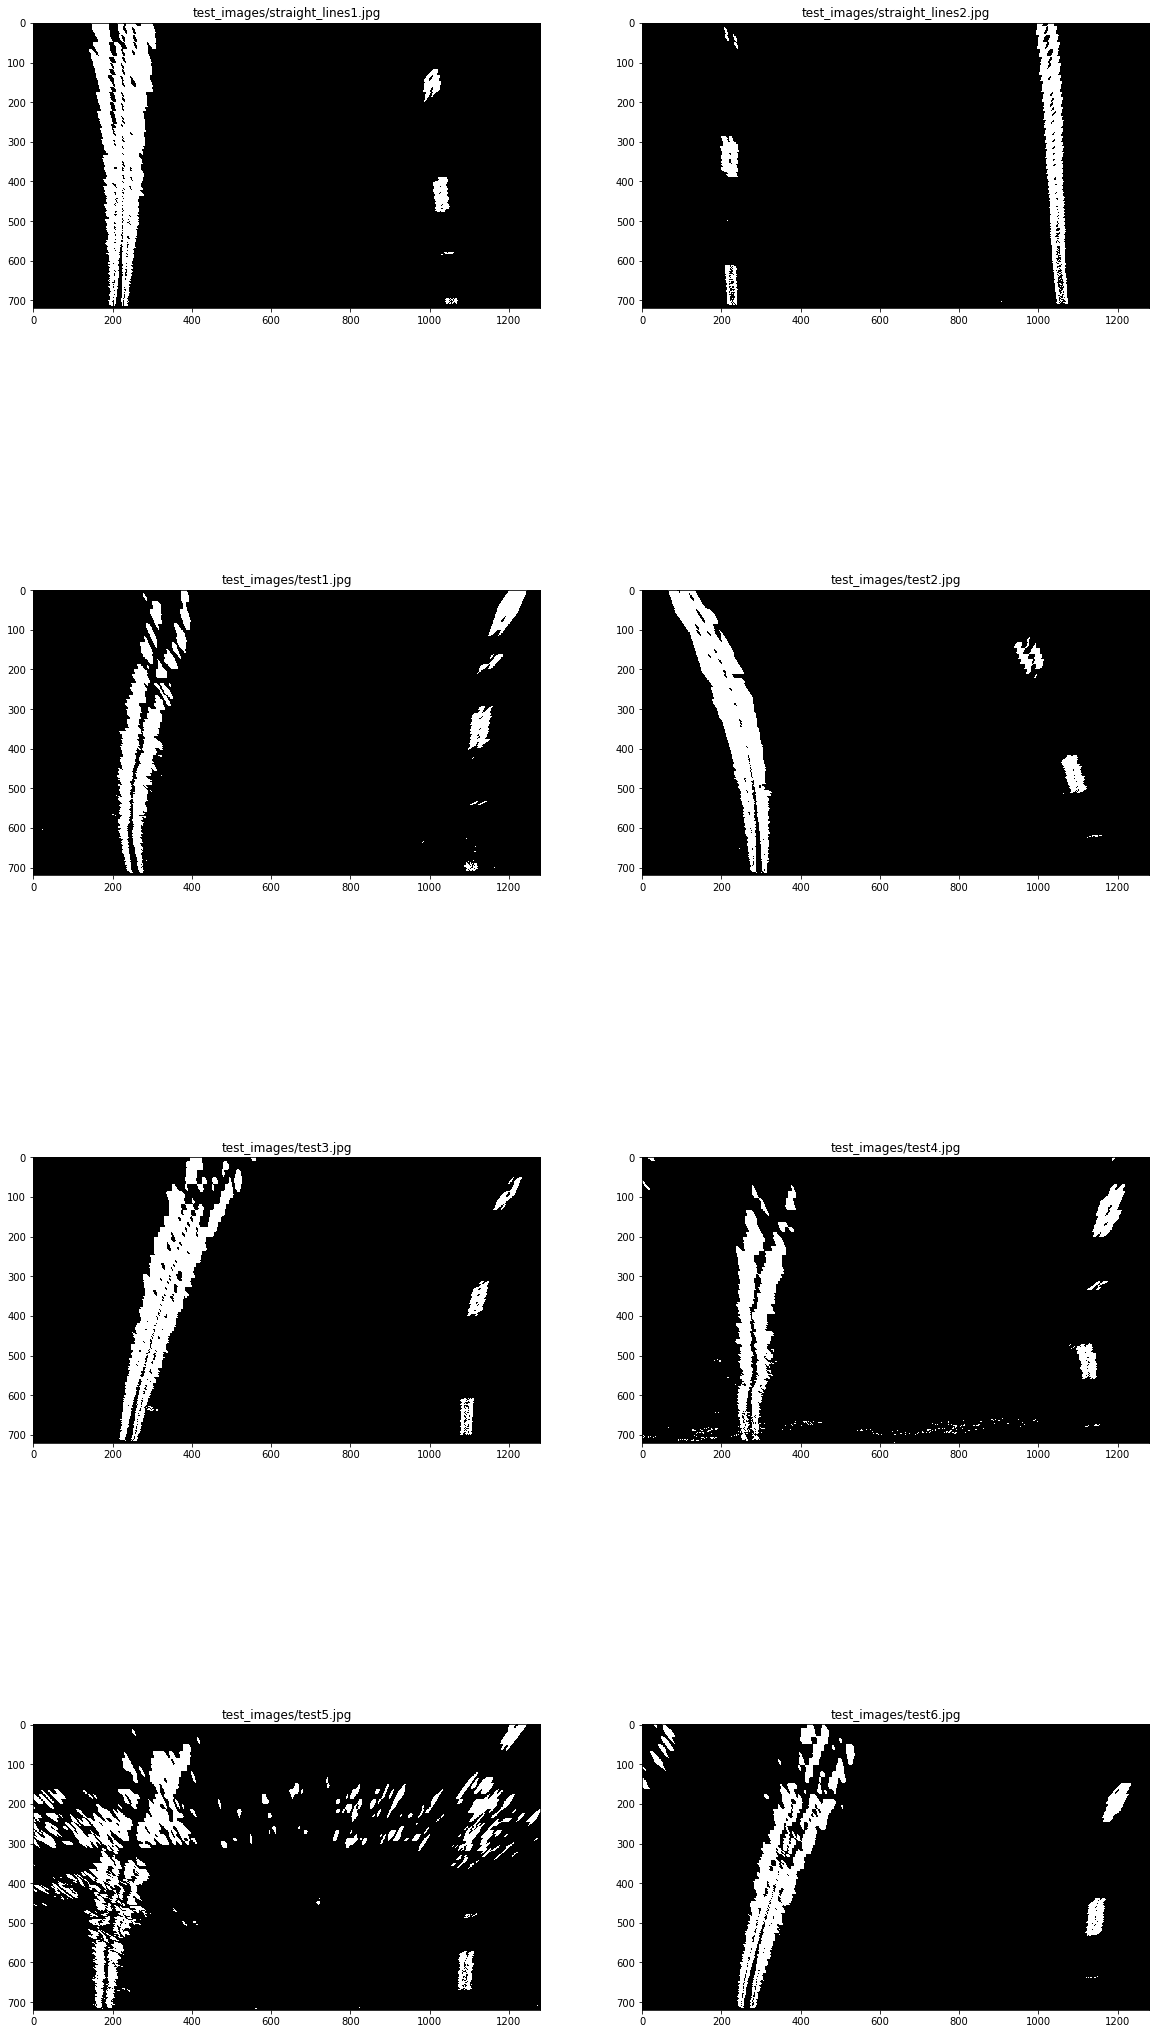

In [6]:
import pickle

def perspective_transform(img):

    
    
    img_size = (img.shape[1], img.shape[0])
    #print(img_size)
    leftupperpoint  = [585,455]
    rightupperpoint = [705,455]
    leftlowerpoint  = [190,720]
    rightlowerpoint = [1130,720]
    
    src = np.float32([leftupperpoint,rightupperpoint,
                      rightlowerpoint,leftlowerpoint])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
    dst = np.float32([[200,0],[img_size[0]-200,0], [img_size[0]-200,img_size[1]],[200,img_size[1]]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size)
    perspective = {"M":M,"Minv":Minv}
    pickle.dump( perspective,open( "pickle/pers.p", "wb" ) )
    
    return warped
  
images = glob.glob('test_images/*.jpg')
fig, axs = plt.subplots(4, 2, figsize=(20, 40))
for ax, img in zip(axs.flat, images):
  path = img
  img = cv2.imread(img)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  undist = cv2.undistort(img, mtx, dist, None, mtx)
  threshold_masked = threshold_mask(undist)
  #roi_img = roi(threshold_masked)
  result = perspective_transform(threshold_masked)
  ax.imshow(result,cmap='gray')
  ax.set_title(path)
  
plt.show() 

In [18]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
 
class glb_vars():
    def __init__(self):
      self.frame_counter = 0
      self.avg_rad = 0
      self.dist_frm_center = 0

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100
    
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
     
    
    
    
    return result,ploty,left_fit,right_fit

#def display_lines()
def pipeline(img):
  #path = img
  #img = cv2.imread(img)
  #plt.imshow(img)
  #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  undist = cv2.undistort(img, mtx, dist, None, mtx)
  threshold_masked = threshold_mask(undist)
  #roi_img = roi(threshold_masked)
  birds_eye_view = perspective_transform(threshold_masked)
  result,ploty,left_fit,right_fit = search_around_poly(birds_eye_view)
  
  return result,ploty,left_fit,right_fit,birds_eye_view,undist

def draw_lanelines(ploty,left_fitx,right_fitx,left_curverad,right_curverad,birds_eye_view,undist,mem_space):
  perspective = pickle.load( open( "pickle/pers.p", "rb" ) )
  Minv = perspective['Minv']
  
  
  
  # Create an image to draw the lines on
  warp_zero = np.zeros_like(birds_eye_view).astype(np.uint8)
  color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
  
  # Recast the x and y points into usable format for cv2.fillPoly()
  pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
  pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
  pts = np.hstack((pts_left, pts_right))

  # Draw the lane onto the warped blank image
  cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
   
  if mem_space.frame_counter % 15 == 0 or mem_space.frame_counter == 1:
  
    curve_rad = (left_curverad + right_curverad)/2
    lane_center = left_fitx[len(left_fitx)-1] + (right_fitx[len(right_fitx)-1] - left_fitx[len(left_fitx)-1])/2
    veh_center = undist.shape[1]/2
 
    mem_space.dist_frm_center = (veh_center - lane_center)*3.7/700
    mem_space.avg_rad = curve_rad
  #print(dist_frm_center)
  # Warp the blank back to original image space using inverse perspective matrix (Minv)
  newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
  font = cv2.FONT_HERSHEY_DUPLEX
  text1 = 'Curve radius: ' + '{:04.2f}'.format(mem_space.avg_rad) + 'km'
  
  
  
  
  cv2.line(newwarp,(np.int32(newwarp.shape[1]//2),720),(np.int32(newwarp.shape[1]//2),650),(255,255,255),5)
  cv2.line(newwarp,(np.int32(newwarp.shape[1]//2),650),(np.int32(newwarp.shape[1]//2+mem_space.dist_frm_center*700/3.7),650),(255,0,0),5)
  text2 = 'Distance from center: '+ '{:04.3f}'.format(mem_space.dist_frm_center) + 'm '
  
  
  cv2.putText(newwarp, text1, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
  cv2.putText(newwarp, text2, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
  
  # Combine the result with the original image
  result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

  return result


  
def main():
  Left_line = Line()
  Right_line = Line()
  mem_space = glb_vars()
  white_output = 'project_video_output.mp4'
  clip = VideoFileClip('/content/drive/My Drive/All_Repos/Self-Driving-Car-NanoDegree/CarND-Advanced-Lane-Lines/project_video.mp4')
  
  def process_image(image):
    mem_space.frame_counter+=1
    result,ploty,left_fit,right_fit,birds_eye_view,undist = pipeline(image)
    
   
    
    # Accumulate the last 5 fits and get the average fit
    if len(Left_line.current_fit) == 2:
      Left_line.current_fit.pop(0)
      Left_line.current_fit.append(np.array(left_fit))
      Left_line.best_fit = np.mean(Left_line.current_fit, axis = 0)
    elif len(Left_line.current_fit) < 2 or None:
      Left_line.current_fit.append(np.array(left_fit))
      Left_line.best_fit = np.mean(Left_line.current_fit, axis = 0)
 
    if len(Right_line.current_fit) == 2:
      Right_line.current_fit.pop(0)
      Right_line.current_fit.append(np.array(right_fit))
      Right_line.best_fit = np.mean(Right_line.current_fit, axis = 0)
    elif len(Right_line.current_fit) < 2 or None:
      Right_line.current_fit.append(np.array(right_fit))
      Right_line.best_fit = np.mean(Right_line.current_fit, axis = 0)
    
    # Use the average fit to draw the left and right lanes
    left_fitx = Left_line.best_fit[0]*ploty**2 + Left_line.best_fit[1]*ploty + Left_line.best_fit[2]
    right_fitx = Right_line.best_fit[0]*ploty**2 + Right_line.best_fit[1]*ploty + Right_line.best_fit[2]
    
    # Get the left and right lane curvatures
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700
    
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    y_eval = np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])/1000
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])/1000
      

    
    if Left_line.radius_of_curvature == None:
      Left_line.radius_of_curvature = left_curverad

    if Right_line.radius_of_curvature == None:
      Right_line.radius_of_curvature = right_curverad


    # Update the best fit lanes if the curvatures are within 2m  tolerance
    if (abs(abs(left_curverad) - abs(right_curverad)) < 2) or (Right_line.bestx is None):
      Left_line.radius_of_curvature = left_curverad
      Right_line.radius_of_curvature = right_curverad
      Left_line.bestx = left_fitx
      Right_line.bestx = right_fitx
  
    result = draw_lanelines(ploty,Left_line.bestx,Right_line.bestx,left_curverad,right_curverad,birds_eye_view,undist,mem_space)
    return result
  edge_clip = clip.fl_image(process_image)
  #[process_image(frame) for frame in clip.iter_frames()]
  %time edge_clip.write_videofile(white_output, audio=False)
    
  
    
    #result = find_lane_pipeline(image)
    #return result

if __name__ == '__main__':
  main()

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4







  0%|          | 0/1261 [00:00<?, ?it/s]




  0%|          | 1/1261 [00:00<03:54,  5.37it/s]




  0%|          | 2/1261 [00:00<03:55,  5.35it/s]




  0%|          | 3/1261 [00:00<03:49,  5.48it/s]




  0%|          | 4/1261 [00:00<03:46,  5.56it/s]




  0%|          | 5/1261 [00:00<03:43,  5.62it/s]




  0%|          | 6/1261 [00:01<03:40,  5.70it/s]




  1%|          | 7/1261 [00:01<03:37,  5.77it/s]




  1%|          | 8/1261 [00:01<03:39,  5.72it/s]




  1%|          | 9/1261 [00:01<03:44,  5.58it/s]




  1%|          | 10/1261 [00:01<03:42,  5.62it/s]




  1%|          | 11/1261 [00:01<03:40,  5.67it/s]




  1%|          | 12/1261 [00:02<03:39,  5.70it/s]




  1%|          | 13/1261 [00:02<03:36,  5.76it/s]




  1%|          | 14/1261 [00:02<03:35,  5.78it/s]




  1%|          | 15/1261 [00:02<03:37,  5.74it/s]




  1%|▏         | 16/1261 [00:02<03:34,  5.80it/s]




  1%|▏         | 17/1261 [00:02<03:34,  5.80it/s]




  1%|▏         | 18/1261 [00:03<03:39,  5

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 17s, sys: 18 s, total: 4min 35s
Wall time: 4min 29s
